# Global Sensitivity Analysis of *PFSS $\to$ WSA $\to$ HUX* for CR2058

In [22]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [38]:
import numpy as np 
import matplotlib.pyplot as plt
import os
from scipy import stats
from model_chain import run_chain_of_models, get_ace_date
from SA_tools.sobol import estimate_sobol
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp
import datetime as dt
from sunpy.coordinates.sun import carrington_rotation_time
import matplotlib
font = {'family' : 'serif',
        'size'   : 20}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

# Get ACE data

In [39]:
# set up carrington rotation
CR = "2058"
start_time = carrington_rotation_time(int(CR)).to_datetime()
end_time = carrington_rotation_time(int(CR)+1).to_datetime()

# get ace data
ACE_longitude, ACE_latitude, ACE_r, ACE_vr, ACE_obstime = get_ace_date(start_time=start_time, end_time=end_time)

# Directory with Results

In [40]:
# directory with results
dir_name = os.getcwd()[:-11] + "/SA_results/CR" + str(CR) + "/LHS"
# number of samples
N_curr = int(10000)
# number of parameters
d = 11

In [41]:
YA_QoI = np.load(file=dir_name + "/simulation_QoI_A.npy")
YB_QoI = np.load(file=dir_name + "/simulation_QoI_B.npy")
YC_QoI = np.load(file=dir_name + "/simulation_QoI_C.npy")

# Ensemble Runs

In [42]:
std_A = np.std(YA_QoI, axis=0)
std_B = np.std(YB_QoI, axis=0)
mean_A = np.mean(YA_QoI, axis=0)
mean_B = np.mean(YB_QoI, axis=0)

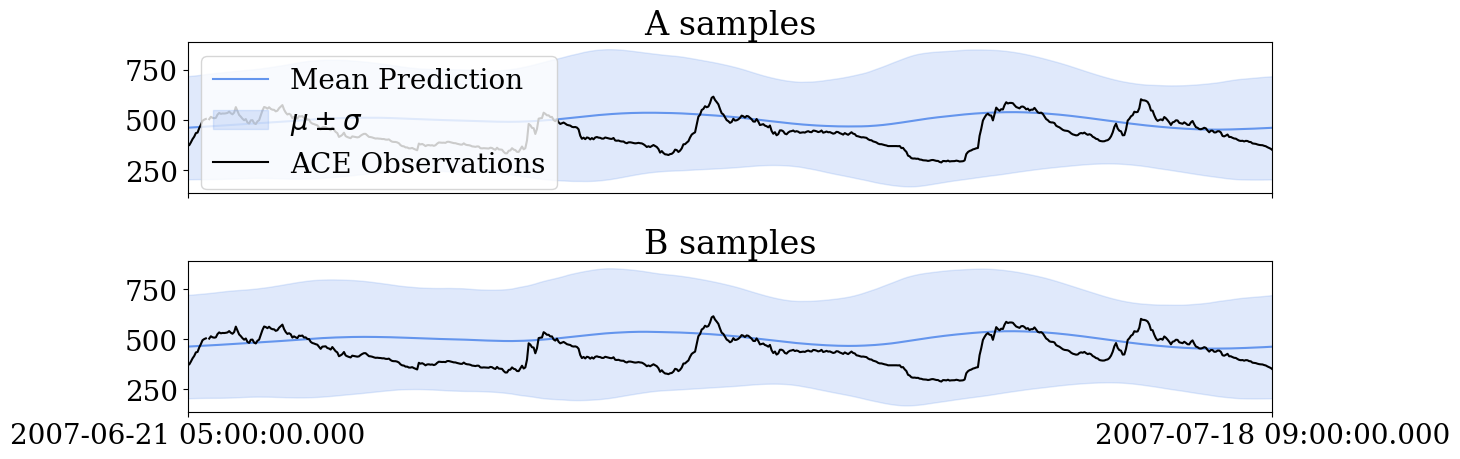

In [43]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(15, 5))
ax[0].plot(ACE_obstime.value, mean_A, c="cornflowerblue", label="Mean Prediction")
ax[1].plot(ACE_obstime.value, mean_B, c="cornflowerblue", label="Mean Prediction")
ax[0].fill_between(ACE_obstime.value, (mean_A-std_A), (mean_A+std_A), 
                   color='cornflowerblue', alpha=.2, label=r"$ \mu \pm \sigma$")
ax[0].plot(ACE_obstime.value, ACE_vr, c="black", label="ACE Observations")
ax[1].fill_between(ACE_obstime.value, (mean_B-std_B), (mean_B+std_B), 
                   color='cornflowerblue', alpha=.2, label=r"$ \mu \pm \sigma$")
ax[1].plot(ACE_obstime.value, ACE_vr, c="black", label="ACE Observations")
ax[0].legend()

ax[0].set_xlim(ACE_obstime[0].value, ACE_obstime[-1].value)
ax[1].set_xlim(ACE_obstime[0].value, ACE_obstime[-1].value)
ax[0].set_xticks(np.linspace(min(ACE_obstime), max(ACE_obstime), 2).value)
ax[0].set_title("A samples")
ax[1].set_title("B samples")
plt.tight_layout()

# Sobol' Sensitivity Indicies


# Samples

In [44]:
# get samples
A = np.load(dir_name + "/samples/A_sample_scaled_10000.npy")[:N_curr, :]
B = np.load(dir_name + "/samples/B_sample_scaled_10000.npy")[:N_curr, :]
np.shape(A)

(10000, 11)

# Compute Indices

In [45]:
color=np.array(mcp.gen_color(cmap="tab20c", n=11))
parameters_label = np.array(["$r_{SS}$", r"$v_{0}$", r"$v_{1}$", r"$\alpha$", r"$\beta$", r"$w$", r"$\gamma$", r"$\delta$", r"$\psi$", r"$ \alpha_{acc}$", r"$r_{h}$"])

In [46]:
main_effect, total_effect = np.zeros((len(ACE_vr), d)), np.zeros((len(ACE_vr), d))

In [47]:
for jj in range(len(ACE_vr)):
    main_effect[jj], total_effect[jj] = estimate_sobol(YA=YA_QoI[:, jj], 
                                                       YB=YB_QoI[:, jj], 
                                                       YC=YC_QoI[:, :, jj], 
                                                       A=A, 
                                                       type_estimator="janon")

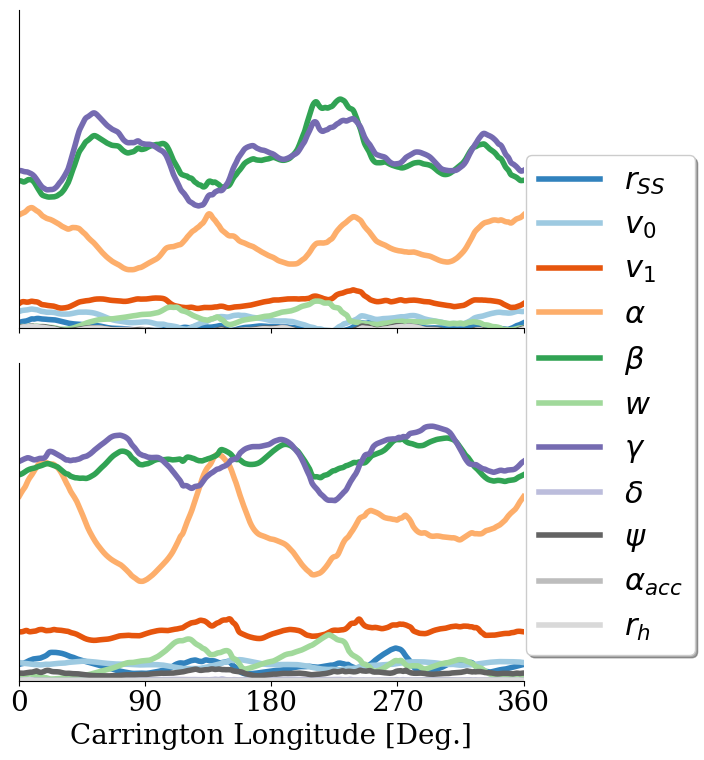

In [66]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 8))
for ii in range(d):
    ax[0].plot(np.sort(ACE_longitude), 100*main_effect[:, ii][np.argsort(ACE_longitude)]/np.sum(main_effect, axis=1), label=str(parameters_label[ii]), color=color[ii], linewidth=4)
    ax[1].plot(np.sort(ACE_longitude), 100*total_effect[:, ii][np.argsort(ACE_longitude)]/np.sum(total_effect, axis=1), color=color[ii], linewidth=4)

ax[0].set_xticks([0, 90, 180, 270, 360])
# ax[0].set_ylabel("first-order \nindices $S_{i}$ %")
# ax[1].set_ylabel("total-order \nindices $T_{i}$ %")
ax[1].set_xlabel("Carrington Longitude [Deg.]")
ax[0].set_ylim(0, 69)
ax[1].set_ylim(0, 45)
ax[0].set_yticks([])
ax[1].set_yticks([])
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[0].set_xlim(0, 360)
fig.legend(loc='upper center', bbox_to_anchor=(1.051, 0.8), ncol=1, fancybox=True, shadow=True, fontsize=22)
plt.tight_layout()
plt.savefig("../figs/GSA/main_and_total_order_time_dependent_CR" + str(CR) + ".png", dpi=600,  bbox_inches='tight')

# Time-dependet Sensitivity Ordering 

In [13]:
main_effect_l2, total_effect_l2 = np.zeros(d), np.zeros(d)
main_effect_inf, total_effect_inf = np.zeros(d), np.zeros(d)
main_effect_l1, total_effect_l1 = np.zeros(d), np.zeros(d)

In [14]:
for ii in range(d):
    # l2 norm
    main_effect_l2[ii] = np.linalg.norm(main_effect[:, ii], ord=None)
    total_effect_l2[ii] = np.linalg.norm(total_effect[:, ii], ord=None)
    # l1 norm
    main_effect_l1[ii] = np.linalg.norm(main_effect[:, ii], ord=1)
    total_effect_l1[ii] = np.linalg.norm(total_effect[:, ii], ord=1)
    # l-inf norm
    main_effect_inf[ii] = np.linalg.norm(main_effect[:, ii], ord=np.inf)
    total_effect_inf[ii] = np.linalg.norm(total_effect[:, ii], ord=np.inf)

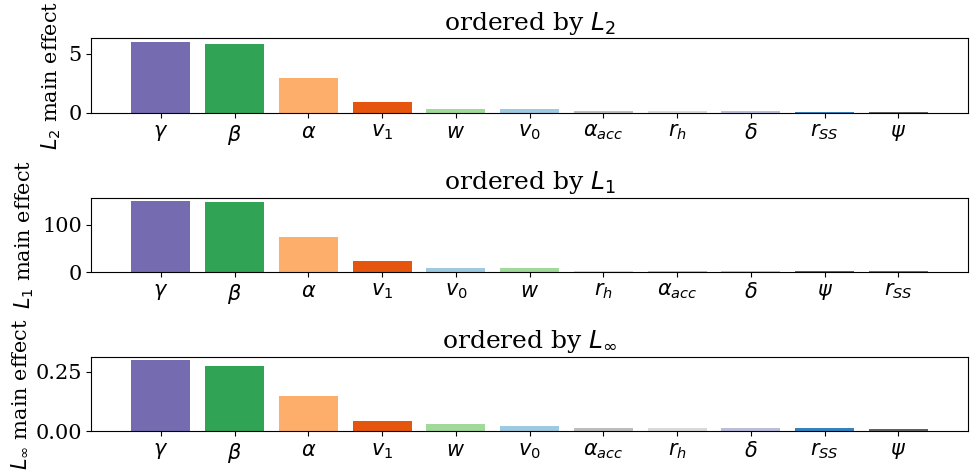

In [15]:
fig, ax = plt.subplots(nrows=3, figsize=(10, 5))
_ = ax[0].set_title("ordered by $L_{2}$")
_ = ax[0].bar(np.arange(d), np.sort(main_effect_l2)[::-1], color=color[np.argsort(main_effect_l2)[::-1]])
_ = ax[0].set_xticks(np.arange(d))
_ = ax[0].set_xticklabels(parameters_label[np.argsort(main_effect_l2)[::-1]])
_ = ax[0].set_ylabel("$L_{2}$ main effect")

_ = ax[1].set_title("ordered by $L_{1}$")
_ = ax[1].bar(np.arange(d), np.sort(main_effect_l1)[::-1], color=color[np.argsort(main_effect_l1)[::-1]])
_ = ax[1].set_xticks(np.arange(d))
_ = ax[1].set_xticklabels(parameters_label[np.argsort(main_effect_l1)[::-1]])
_ = ax[1].set_ylabel("$L_{1}$ main effect")

_ = ax[2].set_title("ordered by $L_{\infty}$")
_ = ax[2].bar(np.arange(d), np.sort(main_effect_inf)[::-1], color=color[np.argsort(main_effect_inf)[::-1]])
_ = ax[2].set_xticks(np.arange(d))
_ = ax[2].set_xticklabels(parameters_label[np.argsort(main_effect_inf)[::-1]])
_ = ax[2].set_ylabel("$L_{\infty}$ main effect")
plt.tight_layout()

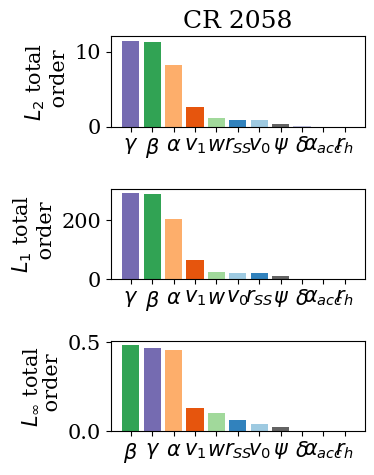

In [16]:
fig, ax = plt.subplots(nrows=3,figsize=(4, 5))
_ = ax[0].set_title("CR " + str(CR))
_ = ax[0].bar(np.arange(d), np.sort(total_effect_l2)[::-1], color=color[np.argsort(total_effect_l2)[::-1]])
_ = ax[0].set_xticks(np.arange(d))
_ = ax[0].set_xticklabels(parameters_label[np.argsort(total_effect_l2)[::-1]])
_ = ax[0].set_ylabel("$L_{2}$ total \n order")

_ = ax[1].bar(np.arange(d), np.sort(total_effect_l1)[::-1], color=color[np.argsort(total_effect_l1)[::-1]])
_ = ax[1].set_xticks(np.arange(d))
_ = ax[1].set_xticklabels(parameters_label[np.argsort(total_effect_l1)[::-1]])
_ = ax[1].set_ylabel("$L_{1}$ total \n order")

_ = ax[2].bar(np.arange(d), np.sort(total_effect_inf)[::-1], color=color[np.argsort(total_effect_inf)[::-1]])
_ = ax[2].set_xticks(np.arange(d))
_ = ax[2].set_xticklabels(parameters_label[np.argsort(total_effect_inf)[::-1]])
_ = ax[2].set_ylabel("$L_{\infty}$ total \n order")
plt.tight_layout()
plt.savefig("../figs/GSA/total_order_time_dependent_CR" + str(CR) + ".png", dpi=600)